# Finding the best place to settle down our company
## Problem analysis
Due to the information found in the different databases (APIs and CSVs), we will divide the problem into two parts. First, we will analyse the databases containing information from all over Europe and look for a location that can meet the first three conditions:
* Having an aerport nearby, i.e. 30 km.
* Having a starbucks nearby, i.e. 1 km
* Not having around companies with more than 10 years, i.e. 1.5 km.

Once we choose the city, we'll narrow down the search so that the company has
* A vegan restaurant, 
* A school, 
* Some pubs, 
* And a conference place nearby

In [1]:
import folium
from IPython.display import Image
from cartoframes.viz import Map, Layer, basic_style, color_category_legend

from SRC.func_part1 import *
from SRC.func_part2 import *

## Part 1
#### 1.1. Airports
We will consult a json file containing the information of all aeroports in the world. We create a *findingLocation()* function to filter those in Europe.

In [2]:
path = "INPUT/airports.json"
airport_df = fromJsonToDF(path)

In [3]:
locationEur = {
    "latmin": 36,  "latmax": 60,    # units in degrees of latitude and longitude
    "longmin": -15,  "longmax": 30,
    "flag": 1
    }
airport_eu = findingLocation (airport_df, **locationEur)

#### 1.2. Starbucks
Let's take a look to this csv containing the location of all Starbucks in the world, and filter those located in Europe.

In [4]:
path = "INPUT/starbucks.csv"

In [5]:
starbucks_df = fromCSVToDF (path)
starbucks_eu = findingLocation (starbucks_df, **locationEur)

#### 1.3. Companies with more than 10 years
Finally, we find in the next MongoDB the companies that are more than 10 years old. To do so, we create a *getDFfromMongoDB()* function which obtains the filtered database according to the query entered by the user and converts it into a dataframe. Again, we filter the result to find those in Europe.

In [6]:
datafromMongo = {
    "dbName": "datamad0320", 
    "collName": "companies", 
    "myquery": {"founded_year": {"$lt":2011}},
    "fields": {"_id":0, "offices.latitude":1, "offices.longitude":1, "offices.country_code":1}
}

In [7]:
oldcompanies_df = getDFfromMongoDB (**datafromMongo)
oldcompanies_cleandf = cleanDFMongo (oldcompanies_df)
oldcompanies_eu = findingLocation (oldcompanies_cleandf, **locationEur)

#### 1.4. Display the results on a map
We plot the results on the map of Europe to have a general overview of the areas where it may be interesting to locate our company. We will use the plotly.graph_objects library.

In [8]:
plotinfo ={
    "df": [airport_eu, starbucks_eu, oldcompanies_eu],
    "names": ["Airport", "Starbucks", "Old companies"],
    "colors": ["royalblue","crimson", "lightseagreen"],
    "markerSize": [15, 12, 10]
}

The *bubbleplot* function creates an interactive map, available in "OUTPUT/bubbleplot.html". By moving the mouse over the map, the closest data are shown.

In [9]:
bubbleplot(**plotinfo)

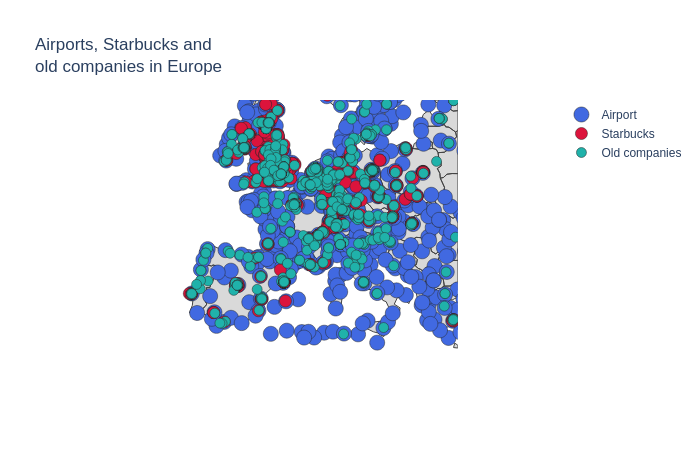

In [10]:
Image("OUTPUT/bubbleplot.png")

This map helps us to narrow down the ideal location area. There are many more cities with airports than cities with Starbucks, so the chain of coffee shops will condition the outcome of this first part. Starbucks are usually located in the main cities of a country although they are not in Eastern Europe yet. Due to the size of the airport and the large number of Starbucks in the city, we decided to look for the ideal location in Madrid.

#### 1.5. Display of the area that meets the first three conditions
With the same *findingLocation()* function we used before, we now filter the elements located in Madrid.

In [11]:
locationMadrid = {
    "latmin": 40.2,  "latmax": 40.7, # units in degrees of latitude and longitude
    "longmin": -4.0,  "longmax": -3.5, 
    "flag": 1
    }

In [12]:
airport_mad = findingLocation (airport_df, **locationMadrid) # 1 airport
starbucks_mad = findingLocation (starbucks_df, **locationMadrid) # 40 starbucks
oldcompanies_mad = findingLocation (oldcompanies_cleandf, **locationMadrid) # 40 old companies

With the *shapely.geometry* library we will create the allowed area for each location, considering a radius of 30km for the airport and 1km for the Starbucks and old companies. We are taking 111 km as the equivalent of one degree of latitude and longitude on the map.

In [13]:
airport_area = addAreaToDF (airport_mad, 30) # 30 km of radius
starbucks_area = addAreaToDF (starbucks_mad, 1) # 1 km of radius
oldcompanies_area = addAreaToDF (oldcompanies_mad, 1) # 1.5 km of radius

*Matplotlib* library allows us to plot the areas around each point of interest. In the *areaPlot()* function we calculate the intersection area of the airport and any starbucks and the difference between the area of a starbucks and that of an old company.

In [14]:
plotinfo ={
    "df": [airport_area, starbucks_area, oldcompanies_area],    
    "colors": ["royalblue","crimson", "lightseagreen"],
    "names": ["Airport", "Starbucks", "Old companies", "Allowed area"]
}

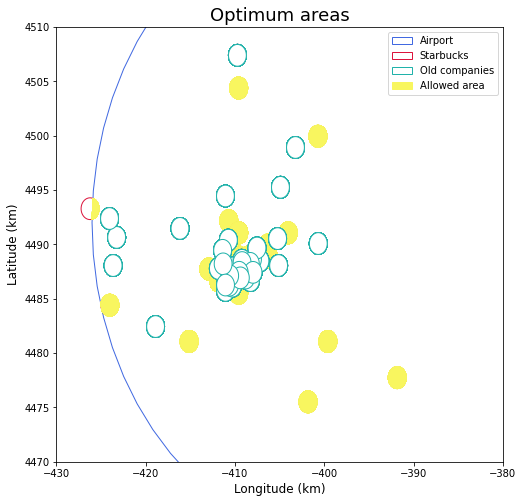

In [15]:
allowed_area, totarea = areaPlot(**plotinfo)

In [16]:
totarea

46.63651543876315

The yellow areas are those in which we can locate our company. We have a total of 46.6 km2 available.
## Part 2
We will narrow down the search by adding more conditions. To know the exactly coordinates of the nearest restaurants, schools, pubs and conference centres, we will use the Foursquare API. In the documentation, we can find some codes that make it easier to find our places of interest.

https://developer.foursquare.com/docs/build-with-foursquare/categories/

#### 2.1. Getting data from Foursquare API

In [17]:
codes = {
    "veggierest": "4bf58dd8d48988d1d3941735", #vegan restaurant
    "elementary": "4f4533804b9074f6e4fb0105", #schools   
    "irishpub": "52e81612bcbc57f1066b7a06", #pubs
    "conference": "5267e4d9e4b0ec79466e48c6" #talks
}

We will create a *fromAPIToDF()* function that connects to the Foursquare API, makes a query and returns a df ready to work with. To do the query we need a starting point, which will be a point in the allowed region that we obtained in the first part.

In [18]:
point = "40.408693,-3.693272" # point inside the allowed area
veggie = FromAPIToDF (codes["veggierest"], point)
school = FromAPIToDF (codes["elementary"], point)
irishpub = FromAPIToDF (codes["irishpub"], point)
conference = FromAPIToDF (codes["conference"], point)

#### 2.2. Plotting places with Cartoframe
To plot the results on the map, we will use the *cartoframe* library. To do this, it is necessary that the points are Geopoints. The function *GeoDF* converts a dataframe into a geodataframe.

In [20]:
airport_geo = GeoDF (airport_area)
starbucks_geo = GeoDF (starbucks_area)
oldcompanies_geo = GeoDF (oldcompanies_area)
veggie_geo = GeoDF(veggie)
school_geo = GeoDF(school)
irishpub_geo = GeoDF(irishpub)
conference_geo = GeoDF(conference)

/home/b/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



Plotting the cartoframes map with different layers:

In [21]:
Map([
    Layer(airport_geo, basic_style(color="royalblue", size=8), legends=color_category_legend(title='airport')),
    Layer(starbucks_geo, basic_style(color="crimson", size=8), legends=color_category_legend(title='starbucks')),
    Layer(oldcompanies_geo, basic_style(color="lightseagreen", size=8), legends=color_category_legend(title='oldcompanies')),
    Layer(veggie_geo, basic_style(color="#ecf023", size=8), legends=color_category_legend(title='veggan')),
    Layer(school_geo, basic_style(color="#fe10de", size=8), legends=color_category_legend(title='school')),
    Layer(irishpub_geo, basic_style(color="#66ee26", size=8), legends=color_category_legend(title='irishpub')),
    Layer(conference_geo, basic_style(color="#bf6ae7", size=8), legends=color_category_legend(title='conference'))
    ],
    legends=color_category_legend(title = "services"))

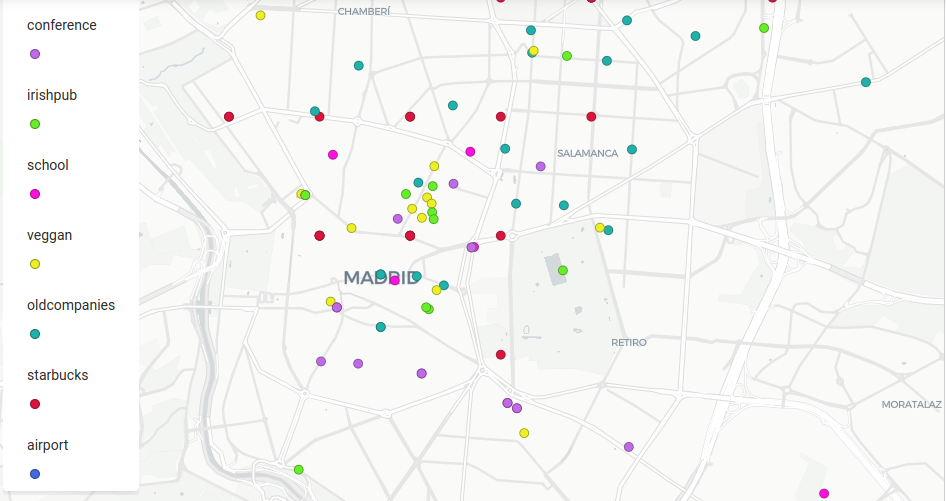

In [22]:
Image("OUTPUT/placesmadrid.png")

#### 2.3. Getting an area that meets the requirements
We realize that there is an area around Chueca - Recoletos without many old companies which has everything necessary nearby. Let's filter the places in this area.

In [23]:
locationB = {
    "latmin": 40.418,  "latmax": 40.426, # units in degrees of latitude and longitude
    "longmin": -3.7,  "longmax": -3.69,
    "flag": 2
    }

In [24]:
starbucks_B = findingLocation (starbucks_area, **locationB)
starbucks_B = starbucks_B.drop_duplicates()
oldcompanies_B = findingLocation (oldcompanies_area, **locationB)
veggie_B = findingLocation (veggie, **locationB)
school_B = findingLocation (school, **locationB)
irishpub_B = findingLocation (irishpub, **locationB)
conference_B = findingLocation (conference, **locationB)

With the function *addAreaToDF* we create an area around each point. All places intersect with the airport area, so it is not necessary to include it.

In [25]:
#airport_area = addAreaToDF (airport_mad, 30) # 30 km of radius
starbucks_areaB = addAreaToDF (starbucks_B, 1) # 1 km of radius
oldcompanies_areaB = addAreaToDF (oldcompanies_B, 1) # 1 km of radius
veggie_areaB = addAreaToDF (veggie_B, 1.5) # 1.5 km of radius
school_areaB = addAreaToDF (school_B, 2) # 2 km of radius
irishpub_areaB = addAreaToDF (irishpub_B, 1.5) # 1.5 km of radius
conference_areaB = addAreaToDF (conference_B, 3) # 3 km of radius

We apply the areaPlot function to plot the intersection areas.

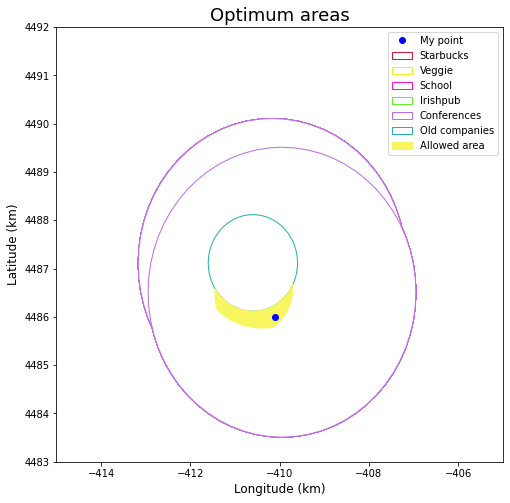

In [27]:
areas = [starbucks_areaB, airport_area, veggie_areaB, school_areaB, irishpub_areaB, conference_areaB, oldcompanies_areaB]
totarea = areaPlot2(*areas)

There are xx km2 where to place our company. We have chosen the blue point in the graph. If we convert this coordinates expressed in km into coordinates expressed in dregees, we will find our perfect location!

In [32]:
x = 4486/111
y = -410.1/111

m = folium.Map()
folium.Marker(location = (x,y)).add_to(m)
m

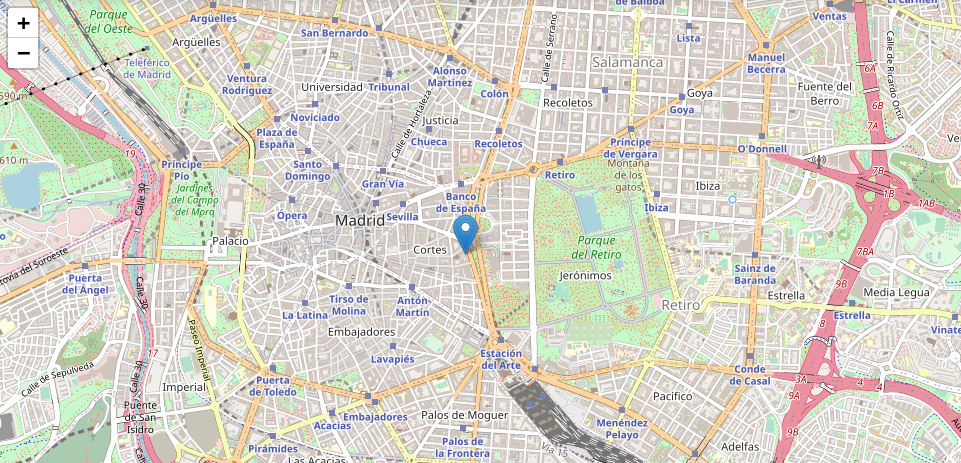

In [33]:
Image("OUTPUT/bestplace.png")